<a href="https://colab.research.google.com/github/iron59zug/YFapi/blob/master/plot_3MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
# plotting three (exponential) moving averages

# libs
import datetime
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import plotly.graph_objects as go # interactive chart

#data
dsrc = 'yahoo'
dsrca = 'stooq'
stox = 'ECONB.BR'
sdate = '2019-06-30'
edate = str(datetime.date.today())
rown = 2

#calculation
sday=30; lday=252; #EMA
STs=5; MTs=21; LTs=63 #MACD

#layout
fs=28; fsx=36; fsy=9
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.style.use('fivethirtyeight')

In [95]:
# data
df = pdr.DataReader(stox, data_source=dsrc, start=sdate)
"""# alternative: use data from a csv file
from google.colab import files
dfu = files.upload()
df = df.set_index(pd.DatetimeIndex(df['Date']))
""" 
df.rename(columns={'High':'h', 'Low':'l', 'Open':'o', 'Close':'c', 
                   'Volume':'vol', 'Adj Close':'ac'}, inplace=True)
# df = df.tail(rown) # only use last x lines of data
dfs = df.iloc[np.r_[0:2, -2:0]]; dfs # show a small sample

,h,l,o,c,vol,ac
Date,,,,,,
2019-07-01,3.238,3.154,3.188,3.190,248300.0,3.067465
2019-07-02,3.262,3.178,3.230,3.184,153584.0,3.061695
2020-07-27,2.315,2.205,2.250,2.315,154808.0,2.315000
2020-07-28,2.345,2.285,2.310,2.315,103841.0,2.315000


In [81]:
# pandas_datareader.stooq.StooqDailyReader(symbols=None, start=None, end=None, retry_count=3, pause=0.1, session=None, chunksize=25)
# Returns DataFrame/dict of Dataframes of historical stock prices from symbols, over date range, start to end
# default_start_date = 5 years before current date
f = web.DataReader(stox,dsrca,start=sdate,end=edate)
f[:rown] # example of calling stooq api, data not used in plt

,Open,High,Low,Close,Volume
Date,,,,,
2020-07-28,1504.0,1564.70,1474.4200,1476.49,15770229
2020-07-27,1435.0,1547.94,1413.0003,1539.60,16048669


In [96]:
# plot asset's adjusted close price, if no split or dividend, adj.close==close
"""
plt.figure(figsize=(fsx, fsy))
plt.title(stox, fontsize=fs)
plt.plot(df['ac'], label='adj.close')
plt.legend(loc='lower right', fontsize=fs); #plt.show()
"""
df.drop(['h','l','o'], axis=1, inplace=True)
#df

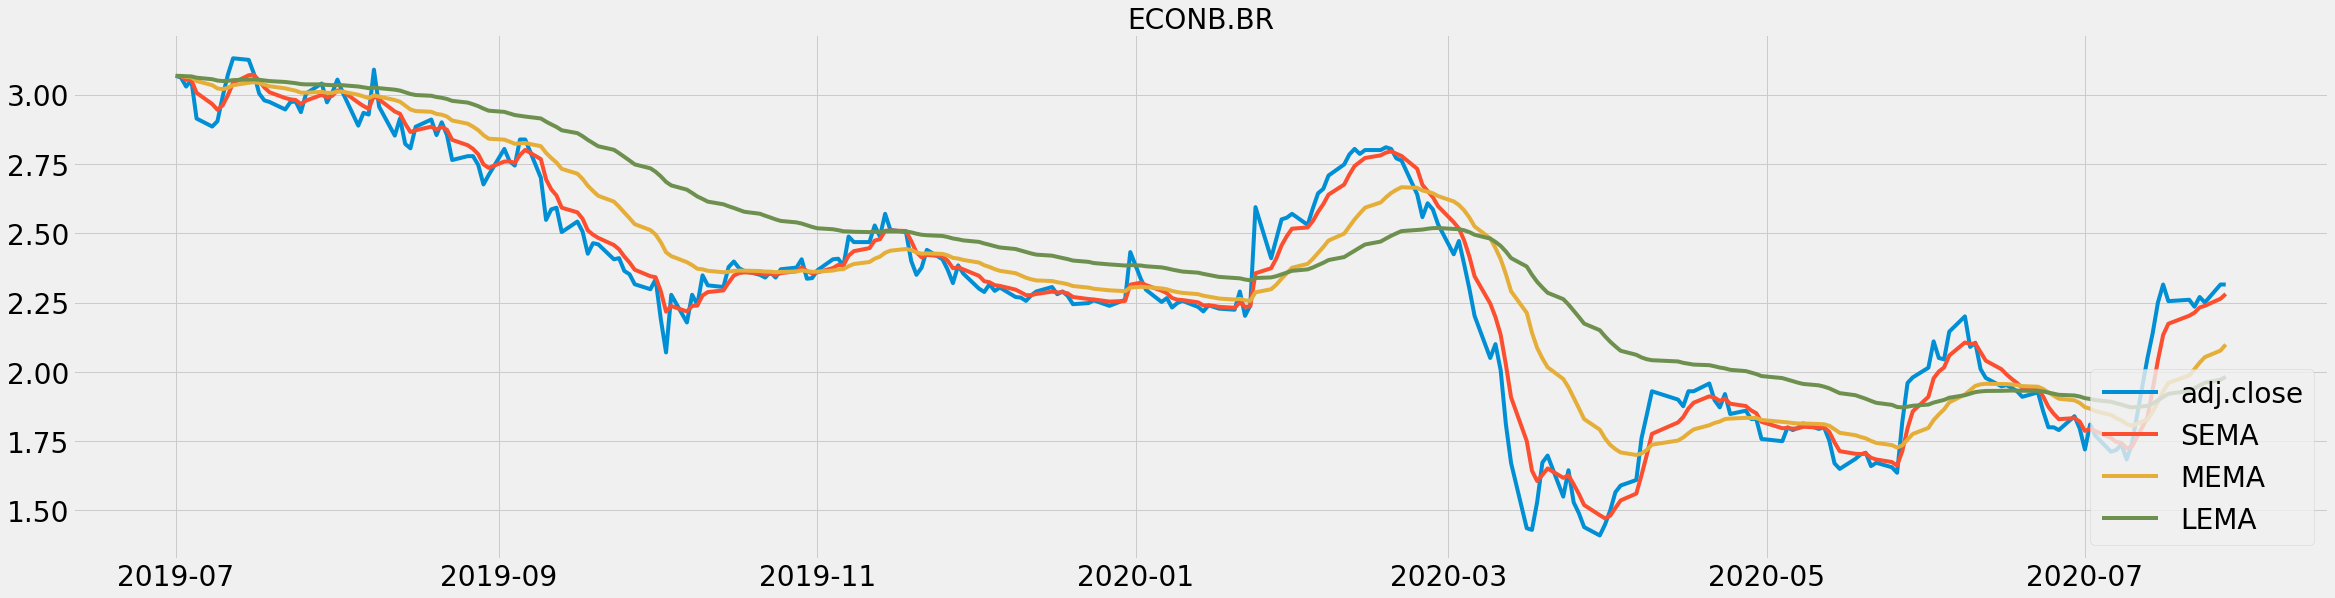

,c,vol,ac,sema,mema,lema
Date,,,,,,
2020-07-22,2.235,100370.0,2.235,2.213230,2.009672,1.940798
2020-07-23,2.270,75822.0,2.270,2.232153,2.033338,1.951086
2020-07-24,2.250,110530.0,2.250,2.238102,2.053035,1.960427
2020-07-27,2.315,154808.0,2.315,2.263735,2.076850,1.971507
2020-07-28,2.315,103841.0,2.315,2.280823,2.098500,1.982241


In [97]:
# calc and plot EMAs
SEMA = df.ac.ewm(span=STs, adjust=False).mean()
MEMA = df.ac.ewm(span=MTs, adjust=False).mean()
LEMA = df.ac.ewm(span=LTs, adjust=False).mean()
df['sema'] = SEMA; df['mema'] = MEMA; df['lema'] = LEMA
plt.figure(figsize=(fsx, fsy))
plt.title(stox, fontsize=fs)
plt.plot(df['ac'], label='adj.close')
plt.plot(SEMA, label='SEMA')
plt.plot(MEMA, label='MEMA')
plt.plot(LEMA, label='LEMA')
plt.legend(loc='lower right', fontsize=fs); plt.show()
df[-5:]

In [98]:
# determine whether Buy Or Sell
def bos_3ma(t):
  buy = []
  sell = []
  lflag = False
  sflag = False

  for i in range(0, len(t)):
    if t['mema'][i] < t['lema'][i] and t['sema'][i] < t['mema'][i] and lflag == False and sflag == False:
      buy.append(t['ac'][i])
      sell.append(np.nan)
      sflag = True
    elif sflag == True and t['sema'][i] > t['mema'][i]:
      sell.append(t['ac'][i])
      buy.append(np.nan)
      sflag = False
    elif t['mema'][i] > t['lema'][i] and t['sema'][i] > t['mema'][i] and lflag == False and sflag == False:
      buy.append(t['ac'][i])
      sell.append(np.nan)
      lflag = True
    elif lflag == True and t['sema'][i] < t['mema'][i]:
      sell.append(t['ac'][i])
      buy.append(np.nan)
      lflag = False
    else:
      buy.append(np.nan)
      sell.append(np.nan)
  
  return(buy, sell)

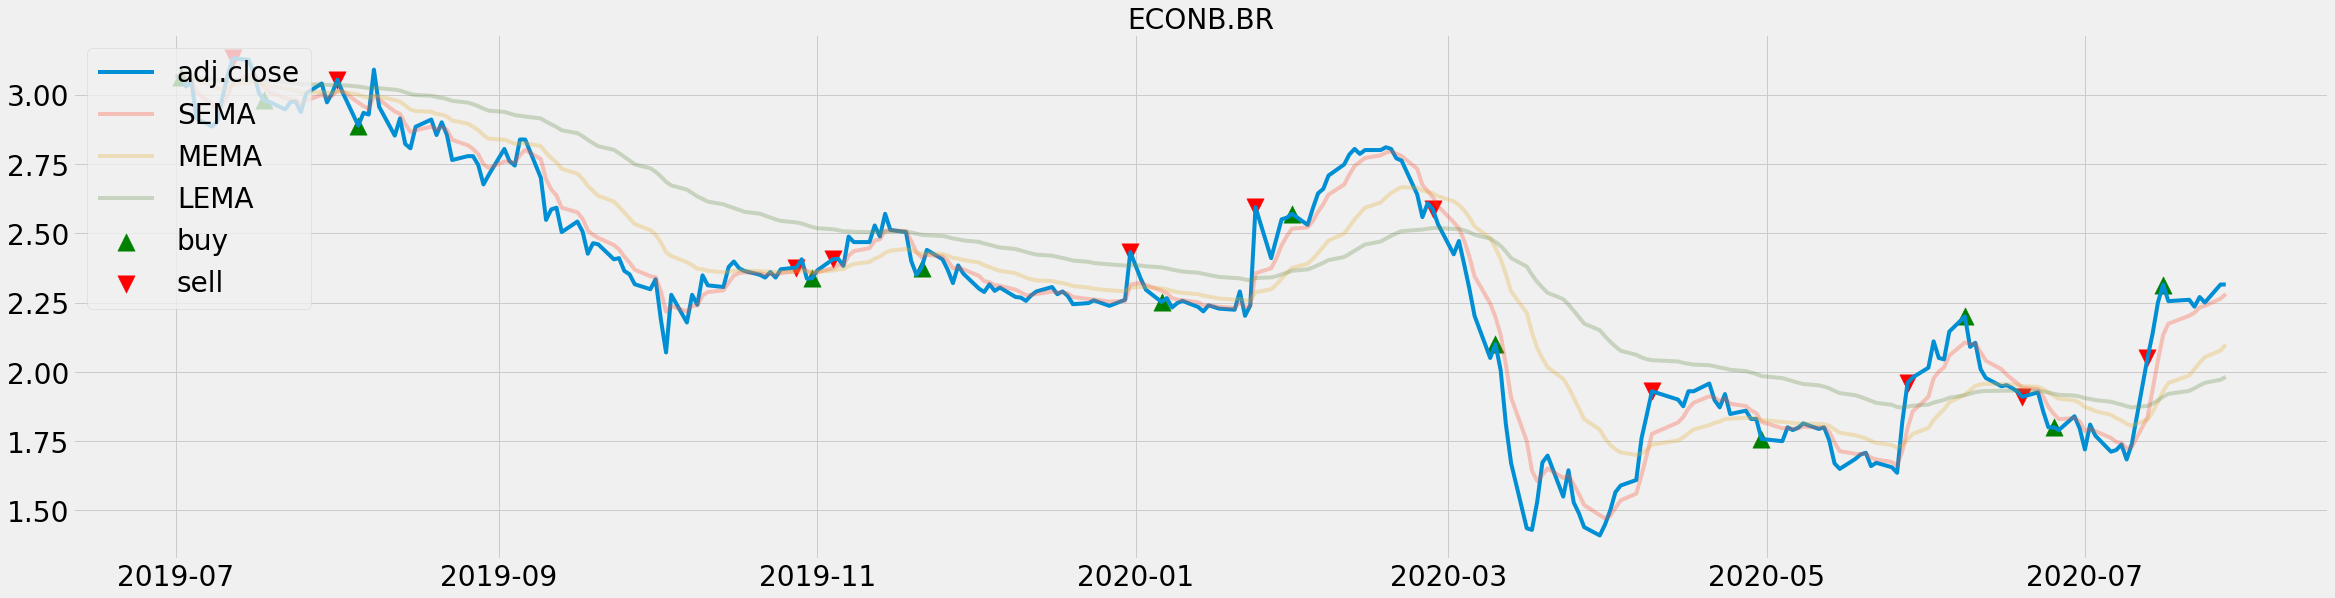

In [101]:
# plot BoS prices
df['buy'] = bos_3ma(df)[0]
df['sell'] = bos_3ma(df)[1]

plt.figure(figsize=(fsx, fsy))
plt.title(stox, fontsize=fs)
plt.plot(df['ac'], label='adj.close')
plt.scatter(df.index, df['buy'], color='green', label='buy', marker='^', s=300)
plt.scatter(df.index, df['sell'], color='red', label='sell', marker='v', s=300)
plt.plot(SEMA, label='SEMA', alpha=0.3)
plt.plot(MEMA, label='MEMA', alpha=0.3)
plt.plot(LEMA, label='LEMA', alpha=0.3)
plt.legend(loc='upper left', fontsize=fs); plt.show()